### Produce Maps

In [1]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import matplotlib.cm as cm
import matplotlib.colors as cls
import matplotlib.colorbar as clb
from matplotlib import gridspec

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
# Make sure to have the font installed (it is on cluster for Harald)
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on HMS Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

import mpl_toolkits
mpl_toolkits.__path__.append('/n/groups/reich/hringbauer/explore_ntbk/jptvenv37/lib/python3.7/site-packages/basemap-1.2.1-py3.7-linux-x86_64.egg/mpl_toolkits/')
from mpl_toolkits.basemap import Basemap

compute-e-16-233.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 28
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


### Do a plot with basemaps

In [2]:
def plot_map_ax(lat, lon, crs=[30, 60, -10, 40], labels=[],
                colors =[], s=40, vrange=[0, 7500], 
                cmap="viridis_r", map_title="", 
                title_loc=(0.1,0.1), lw=1.0, ec="k",
                fs_label=14, figsize=(12,11), states=False, countries=False, 
                fs_labels=14, ew=0.5, y_off=1, title="", plot_mod=True, 
                vrange_a=[], mm=3.1, hspace=0.02, fs=18, col_cont = "#d9d9d9", col_lake = "#d9d9d9", 
                show=True, lw_coast=0.5, res="i", savepath=""): 
    """Plot a continent, based on coordinates in df
    lat, lon: Arrays of coordinates to plot
    crs: [4], Corners of plot (lat and then lon)
    vrange: Normalization range for color [cM]
    shiftlong: Add to longitude (in cases for map on South America)
    vrange_a: The Age Range to Plot
    col_cont: Color of the Continent: "#d9d9d9" is very faint gray from Sardinia paper
    lw: Width of Scatter point edges
    ec: Color of Scatter point edges
    res: Resolution of Coastline: c l m i h"""
    if len(colors)==0:
        colors="gray"
    cmap = cm.get_cmap(cmap)
    norm = plt.Normalize(vrange[0], vrange[1]) 
    
    m = Basemap(projection='merc', llcrnrlat=crs[0], urcrnrlat=crs[1],\
                llcrnrlon=crs[2], urcrnrlon=crs[3], resolution=res, ax=ax)  # mill
    m.fillcontinents(color=col_cont, zorder=0, lake_color=col_lake)
    #m.etopo(scale=0.5, alpha=0.4)  # Topological Map
    m.drawcoastlines(color='gray', zorder=0, linewidth=lw_coast)
    if countries:
        m.drawcountries(color="dimgray")
    if states:
        m.drawstates()
        
    coords = np.array([m(lon[i],lat[i]) for i in range(len(lon))])
    x,y = np.array(coords[:,0]), np.array(coords[:,1])
    ax.scatter(x, y, c=colors, ec=ec, lw=lw, s=s, cmap=cmap, norm=norm, zorder=3)
    
    if len(labels)>0:
        for i, txt in enumerate(labels):
            ax.text(x[i], y[i]+y_off, txt, fontsize=fs_labels, zorder=1, ha="center", clip_on=True)

    if len(title)>0:
        ax.set_title(title, fontsize=fs_labels)
    if len(map_title)>0:
        ax.text(title_loc[0], title_loc[1], map_title,
                fontsize=fs, transform=ax.transAxes, ha="left", va="bottom")
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved to {savepath}")    
    
    if show:
        plt.show()

### Load the Data (always required)

In [3]:
df = pd.read_csv("./data/meta/v43_meta0.csv", sep="\t")
df["Lat"] = pd.to_numeric(df["Lat."], errors="coerce")
df["Lon"] = pd.to_numeric(df["Long."], errors="coerce")
df["age"] = pd.to_numeric(df['Average of 95.4% date range in calBP (defined as 1950 CE)  '], errors="coerce")
df["iid"] = df["Master ID"]

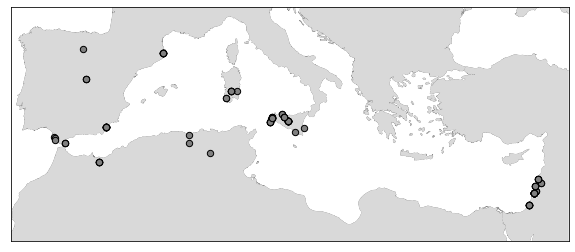

In [4]:
plt.figure(figsize=(10,5))
ax = plt.gca()
plot_map_ax(df["Lat"], df["Lon"],  crs=[29, 45, -10, 38], 
            fs_labels=10, y_off=6e4,
            savepath="")
plt.show()

# Non-Interactive Map of Sample

In [5]:
### Code to Produce the Offset:
def perfect_pos_text1(x, y, max_dist=1, offset=1):
    """LEGACY CODE: Optimizes the position of labels. Moves labels by offset
    down in case max_dist
    x,y: nx1 arrays
    max_dist: 0.5
    offset: THe new offset to be added.
    Return: New coordinates x,y as nx1, nx1 arrays"""
    coords = np.stack((x,y), axis=1)
    new = np.array([coords[0],])
    
    for xy in coords[1:]:
        while True:
            dists = np.sum((new - xy) ** 2, axis=1)
            if np.min(dists) < max_dist**2:
                xy[1] += offset # Add Offset if Needed!
            else:
                new = np.concatenate((new, [xy]), axis=0)
                break
    return coords[:,0], coords[:,1]

### Helper Functions
def set_clusters(coords, max_dist):
    """Determine clusters based on coordinates, everything within max_dist
    is included in cluster"""
    
    clusters = np.zeros(len(x), dtype="int")  # The Placeholder for the Cluster Items
    cur_clus = 1

    for i, xy in enumerate(coords):
        if clusters[i] == 0:
            dists = np.sum((coords - xy) ** 2, axis=1)  # Calculate Distances with all existing Nodes
            same = dists < max_dist   # Identify all nearby points
            assert(np.sum(same)>0)    # Sanity Check
            clusters[same] = cur_clus # Set all to current cluster
            cur_clus += 1             # Increase the current cluster 
    return clusters, cur_clus

def new_coordinates(coords, v_offset):
    """Set new coordinates"""
    x_m = np.mean(coords[:,0])
    y_m = np.mean(coords[:,1])
    
    x_coords = np.ones(len(coords)) * x_m # C Coordinates are same
    #y_coords = np.argsort(coords[:,1]) * v_offset  # Would sort by Y
    y_coords = np.arange(len(coords)) * v_offset   # Same ordering (so totally by alphabetical order)
    y_coords = y_coords + y_m - v_offset * len(y_coords) / 2 # Center
    return np.stack((x_coords, y_coords), axis=1)
      
def perfect_pos_text(x, y, max_dist=1, offset=1):
    """Optimizes the position of labels. Moves labels by offset
    down in case max_dist
    x,y: nx1 arrays
    max_dist: Maximum Distance 
    offset: THe new offset to be added.
    Return: New coordinates x,y as nx1, nx1 arrays"""
    
    coords = np.stack((x,y), axis=1)
    clusters, max_clus = set_clusters(coords, max_dist)
    ### Postprocess all clusters:
    for i in range(1, max_clus):
        clst_inds = (clusters == i)
        assert(np.sum(clst_inds)>0) # Sanity Check if clusters are filled up
        
        t_coords = coords[clst_inds, :] # Extract Coordinates
        coords[clst_inds,:] = new_coordinates(t_coords, offset) # Set to new coordinates
    
    return coords[:,0], coords[:,1]

def man_update(x, y, labels, target, x_delta, y_delta):
    """Manually update labels that begin with target [str].
    Shift by x_delta and y_delta
    Return new x, y coordinates"""
    assert(len(x)==len(labels))
    
    idx = np.core.defchararray.startswith(labels, target)
    x[idx] = x[idx] + x_delta
    y[idx] = y[idx] + y_delta
    return x, y

Dropping 174 missing Coordinates


NameError: name 'x_n' is not defined

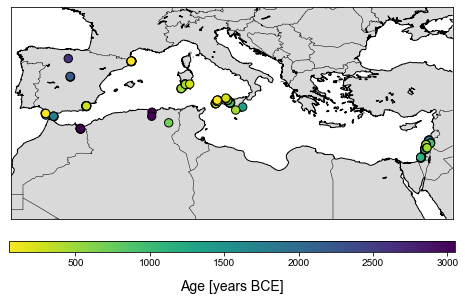

In [6]:
### Load the data
df = pd.read_csv("./data/meta/v43_meta0.csv", sep="\t")
df["Lat"] = pd.to_numeric(df["Lat."], errors="coerce")
df["Lon"] = pd.to_numeric(df["Long."], errors="coerce")
df["age"] = pd.to_numeric(df['Average of 95.4% date range in calBP (defined as 1950 CE)  '], errors="coerce")
df["iid"] = df["Master ID"]
df = df.sort_values(by="age", ascending=False)

### set the Parameters
jitter = 0.1
plotlim = np.array([2000, 5000]) # Which time (BCE!) to actually plot (first values should be same as ovlim) [2800, 7500]
ovlim = [2000, 5000] # For Colormap used in PCA # [2800, 8000]
p = 1950            # Present: To transform to BCE
coords = [25, 48, -10, 38]
figsize = (8, 4.5)
#width_ratios = [40, 1]
height_ratios=[20,1]
savepath = ""
res = "i" # i.. itmte h .. high f ... full (takes 2min)

col_cont = "#d9d9d9"
col_lake = "#d9d9d9"


idx = pd.isna(df["Lat"])
print(f"Dropping {len(idx)} missing Coordinates")
df = df[~idx]

lat = df["Lat"].values 
lon = df["Lon"].values 

age = df["age"].values
labels = df["iid"].values.astype("str")

min_age, max_age = np.min(age), np.max(age)

################
#### Add Jitter
lat_jit = lat + jitter * np.random.random(len(lat)) - jitter/2
lon_jit = lon + jitter * np.random.random(len(lon)) - jitter/2

### Do the Color Maps
# Do the Color Maps
cmap = cm.get_cmap("viridis_r", 15)
norm = plt.Normalize(ovlim[0], ovlim[1])

### Do the custom part of the color map to plot
vmin, vmax =plotlim[0], plotlim[1]  #minimum, maximum value to show on colobar
norm_c = cls.Normalize(vmin=vmin -p, vmax =vmax-p)  # Shift normalization to BCE

#generate colors from original colormap in the range equivalent to [vmin, vamx] 
colors_t = cmap(np.linspace(0, (plotlim[1]-plotlim[0])/(ovlim[1]-ovlim[0]), cmap.N))
cmap_c = cls.LinearSegmentedColormap.from_list('asdf', colors_t) # Create a new colormap from those colors 

### Produce the dot Map
#ecs = ["black" if (i == 1) else "r" for i in df["include_alt"]] # Only marker boarder for good samples
ecs = ["black" for i in range(len(lat))]

# Prepare the Face colors
#facemap = {"Sar-N_ECA": cmap(norm(5500)), "Sar-EBA": cmap(norm(4000)), 
#           "Sar-Nur": cmap(norm(3200)),"Sar-Vil": cmap(norm(2600)), "Sar-MS": cmap(norm(2400)), 
#           "Sar-AMC": cmap(norm(1800)), "Sar-Med" : cmap(norm(700)) , "Sar--9" : "lightgray"}

#fcs = list(map(facemap.get, ancsard_df.clst))
fcs = [cmap(norm(i)) for i in age]

### Actual Plot
fig = plt.figure(figsize=figsize) 
gs = gridspec.GridSpec(2, 1, height_ratios=height_ratios) # Third axis is just to get space!
ax = plt.subplot(gs[0]) # The left subplot
ax1 = plt.subplot(gs[1]) # The middle one (for map)

m = Basemap(projection='mill', llcrnrlat=coords[0], urcrnrlat=coords[1],\
            llcrnrlon=coords[2], urcrnrlon=coords[3], ax=ax, resolution = res,
             epsg=4326) # res [i]tmdate, [h]igh, [f]ull

#m.bluemarble()
m.fillcontinents(color=col_cont, zorder=0, lake_color=col_lake)
m.drawcoastlines()
m.drawcountries()
#m.drawstates()

# Convert all coordinates to basemap coordinates:
coords = np.array([m(lon[i],lat[i]) for i in range(len(lon)) ])
coords_jit = np.array([m(lon_jit[i],lat_jit[i]) for i in range(len(lon)) ])

x,y = np.array(coords[:,0]), np.array(coords[:,1])
x_jit, y_jit = np.array(coords_jit[:,0]), np.array(coords_jit[:,1])

coll = ax.scatter(x_jit, y_jit, c = fcs, alpha=1, 
                  edgecolors=ecs, zorder=2, s=70)

cb1 = clb.ColorbarBase(ax1, cmap=cmap_c,
        norm=norm_c, orientation='horizontal')
cb1.ax.tick_params(axis='y', direction='in')
ax1.set_xlabel("Age [years BCE]", fontsize=14, rotation=0, labelpad=12)

### Write the text:
#x_n, y_n = perfect_pos_text(x+0.09, y-0.04, max_dist=0.04, offset = 0.045) # Calculate the new spacing

### Postprocess the final text
x_n, y_n = man_update(x_n, y_n, labels, "SUC", x_delta=-0.12, y_delta=0.08)

### Adjust position of subplots
plt.subplots_adjust(left=0, bottom=0.05, right=None,
         wspace=0.03, hspace=0.01)

if len(savepath)>0:
    plt.savefig(savepath, 
                bbox_inches = 'tight', pad_inches = 0)  # Save if needed

plt.show()